# Introduktion

Denna notebook presenterar en statistisk analys av bostadspriser i Kalifornien med hjälp av multipel linjär regression.   
Syftet är att undersöka hur olika kvantitativa variabler samt närhet till havet påverkar medianvärdet av bostadspriser.

Regressionen implementeras från grunden med Ordinary Least Squares (OLS) och analysen omfattar skattning av modellparametrar, signifikansprövning, beräkning av förklaringsgrad samt konstruktion av konfidensintervall. Eventuell kollinearitet mellan prediktorer undersöks med hjälp av Pearsons korrelationskoefficient.

Fokus ligger på att förstå och tolka resultaten statistiskt snarare än att göra numeriska förutsägelser.


# Metod

Importering av bibliotek, data och modell(klassen), samt kopia av datan(för att inte råka göra ändringar i orginaldatan):  

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats


df = pd.read_csv("housing.csv")
df = df.copy()

#### Övergripande analys av datan

In [2]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Kollar vilka typer av värden som finns i variablerna  
(numeriska: int, float och/eller kategoriska: object?)

Det gör jag för att identifiera kategoriska variabler (som behöver omvandlas till nomeriska om jag vill ha med dem i min linjära regression). 

In [3]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

"ocean_proximity" = kategorisk variabel med dtype: object  


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Kollar efter saknade värden: 

In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Kollar standardavvikelsen procentuellt för att få en tydligare bild av den: 

In [6]:
df.describe().loc['std'] / df.describe().loc['mean'] * 100  

longitude             -1.675618
latitude               5.994501
housing_median_age    43.944774
total_rooms           82.769778
total_bedrooms        78.343213
population            79.444447
households            76.536413
median_income         49.082490
median_house_value    55.785531
dtype: float64

Alla kategorier har medel till hög standardavvikelse (bortser från koordinaterna, då de inte säger så mycket här). Det kan bero på att skillnaden mellan områderna är stora, både gällande storleken på området som mätts och stora skillnader i hur många bostäder som finns i området. För att visualisera avvikelsen gör jag en boxplot: 

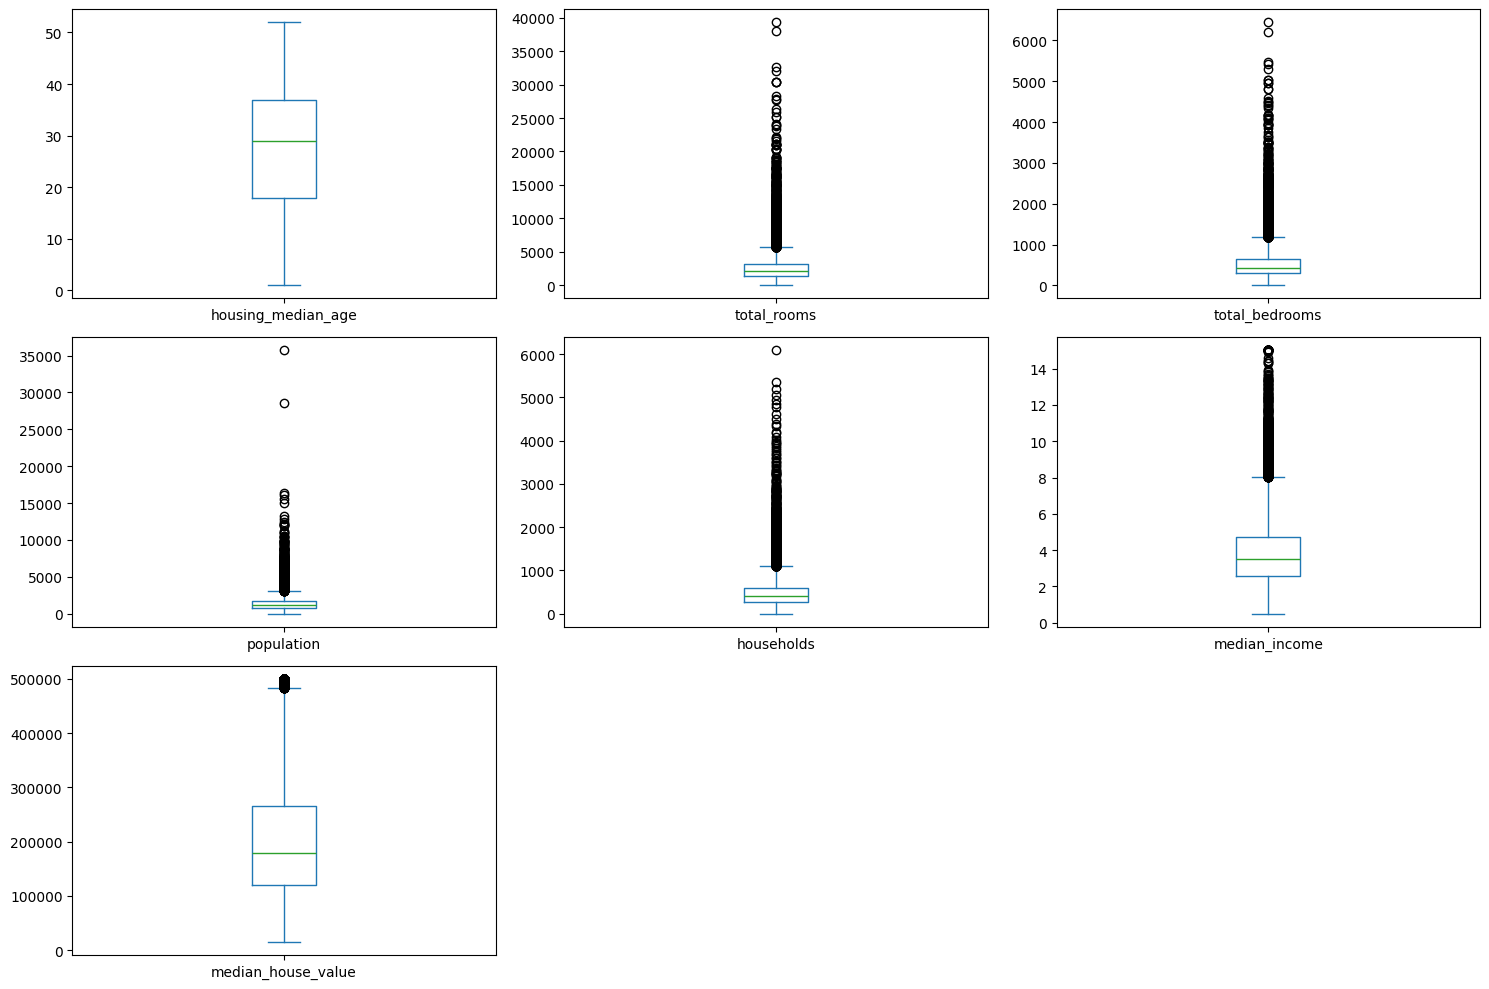

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.drop(['longitude', 'latitude'])      
df[num_cols].plot(kind='box', subplots=True, layout=(3, 3), figsize=(15, 10))
plt.tight_layout()
plt.show()  


Kollar även om det kan finns någon korrelation med Pearson-korrelation: 

In [8]:
df[["median_house_value", "population", "households", "median_income", "total_rooms", "total_bedrooms", "housing_median_age"]].corr()

,median_house_value,population,households,median_income,total_rooms,total_bedrooms,housing_median_age
median_house_value,1.000000,-0.024650,0.065843,0.688075,0.134153,0.049686,0.105623
population,-0.024650,1.000000,0.907222,0.004834,0.857126,0.877747,-0.296244
households,0.065843,0.907222,1.000000,0.013033,0.918484,0.979728,-0.302916
median_income,0.688075,0.004834,0.013033,1.000000,0.198050,-0.007723,-0.119034
total_rooms,0.134153,0.857126,0.918484,0.198050,1.000000,0.930380,-0.361262
total_bedrooms,0.049686,0.877747,0.979728,-0.007723,0.930380,1.000000,-0.320451
housing_median_age,0.105623,-0.296244,-0.302916,-0.119034,-0.361262,-0.320451,1.000000


median_income har en stak korrelation (0.69) med median_house value. Kan därför användas vid en linjär regression. 

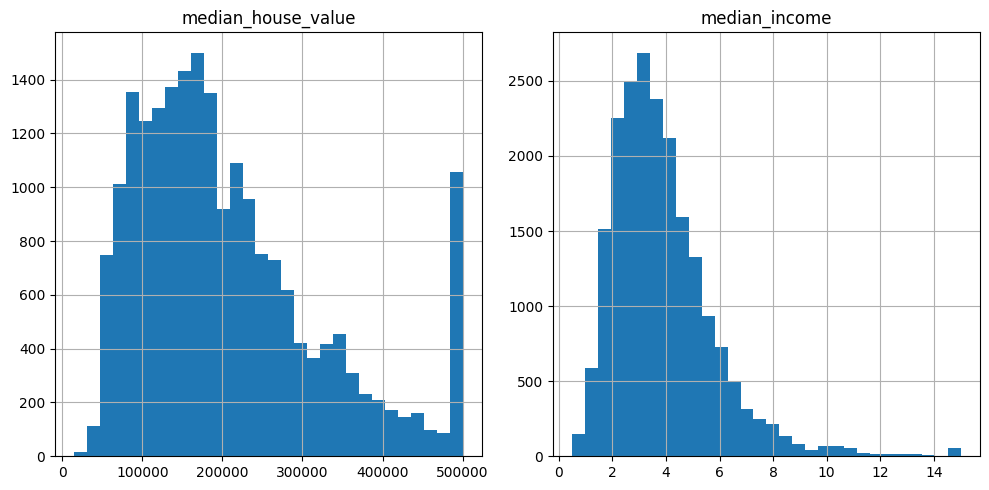

In [9]:
# histogram för att se fördelningen av median_house_value och median_income
df[["median_house_value", "median_income"]].hist(bins=30, figsize=(10, 5))
plt.tight_layout()  
plt.show()  

I median_house_value syns en tydlig topp vilket indikerar att det finns en "cap" (kapad) vid 500.000, vilket kan påverka regressionsanpassningen om den används som y. Annars ser båda ut att ha någon form av mönster. Ytterligare att notera är att båda är högerskeva och har långa svansar (median_value_house mer extrem) - ett mindre antal observationer har betydligt högre värden än majoriteten, vilket indikerar på extrema värden i datan. Extrema värden som dessa påverkar skattningen vid OLS, vilket är bra att ha i åtanke. 

I och med att standardavvikelsen är stor väljer jag att skapa en ny variabel som mäter medelvärde på hur många personer som bor i varje hushåll per område. Då får vi en bättre värde än att bara använda exempelvis "population", då områdenas storlek skiljer sig mycket. 

Då kan jag undersöka om områden som är mer trångbodda har något samband med huspriser (och geografiskt). Socioekonomisk indikator? 

In [10]:
df["persons_per_household"] = df["population"] / df["households"]


Kollar om det ser ut att finnas korrelation mellan persons_per_houshold och median_house_value: 

In [11]:
df[["median_house_value", "persons_per_household"]].corr()

,median_house_value,persons_per_household
median_house_value,1.000000,-0.023737
persons_per_household,-0.023737,1.000000


Ser inte ut som att det finns något tecken på korrelation. Därför kan vi utesluta denna kategori vid val av median_house_value som målvariabel. Syftet med den linjära regressionen är ju att se om vi med hjälp av X förutspå y. Därmed väljer jag bara parametrar som visar tecken på korrelation. 

#### Vidare analys av den kategoriska variabeln ocean_proximity

 Kollar vilka värden som finns i ocean_proximity för att sedan kunna göra om dem till numeriska värden: 

In [12]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Kollar också antalet värden per kategori för att få syn på vilka som är vanligast och om det finns väldigt få av några (viktigt vid tolkning sedan): 

In [13]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

För att ännu tydligare se propotionerna (hur vanligt förekommande i kategorin):

In [14]:
df["ocean_proximity"].value_counts(normalize=True)

ocean_proximity
<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: proportion, dtype: float64

ISLAND - få av detta värde. Vid interpretation av regressionskoeffficienter måste man ha detta vid åtanke, då det kan leda till stora standardfel och "konstiga" koefficienter.  
  
Gör en scatterplot med hjälp av koordinaterna och hur de kategoriserats utifrån "ocean_proximity". på så sätt får jag en visuell överblig över datan: 

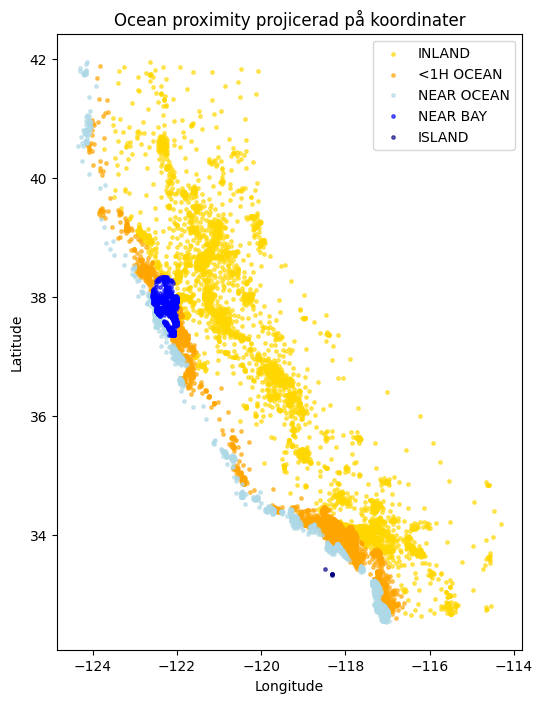

In [15]:
import matplotlib.pyplot as plt

color_map = {
    "INLAND": "gold",
    "<1H OCEAN": "orange",
    "NEAR OCEAN": "lightblue",
    "NEAR BAY": "blue",
    "ISLAND": "navy"
}

plt.figure(figsize=(6, 8))

for category, color in color_map.items():
    subset = df[df["ocean_proximity"] == category]
    plt.scatter(
        subset["longitude"],
        subset["latitude"],
        s=6,
        color=color,
        label=category,
        alpha=0.6
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Ocean proximity projicerad på koordinater")
plt.show()

Tydligt att värden är som en skala utifrån närhet till havet. där INLAND är längst från havet och NEAR OCEAN(inklusive NEAR BAY och ISLAND) ligger närmast havet. Då kan man tänka sig att vi också skulle kunna sätta värden "skalamässigt", när vi gör om dem från kategoriska till numeriska på ett sådant sätt att de inte bara ses som namn, utan som grader.  
  
Exempelvis högst poäng - närmast havet(Ordinalskala).   
  
Dock blir avståndet mellan dem oklara.. Så ändå bäst att hålla sig till en "nominalskala" (där de olika värdena inte rangordnas).   
  
Testar korrelationen med house_median_value utifrån en satt skala på de olika värdena bara för kolla hur det ser ut: 

In [16]:
Index_ocean_proximity = {
    "INLAND": "1",
    "<1H OCEAN": "2",
    "NEAR OCEAN": "3",
    "NEAR BAY": "3",
    "ISLAND": "3"
}
df["Index_ocean_proximity"] = df["ocean_proximity"].map(Index_ocean_proximity).astype(int)

df[["median_house_value", "Index_ocean_proximity"]].corr()

,median_house_value,Index_ocean_proximity
median_house_value,1.000000,0.436212
Index_ocean_proximity,0.436212,1.000000


Utifrån Pearsons korrelation har avstånd till havet och huspriser (efter jag satt värdena) ett måttligt starkt linjärt samband. Det ger oss anledning att ha med variabeln i vår linjära regression senare. Då kommer jag dock använda mig av dummies där jag inte sätter värdet själv i förväg, för att undvika selektionsbias. Sambandet sysn även i stapeldiagrammet nedan: 

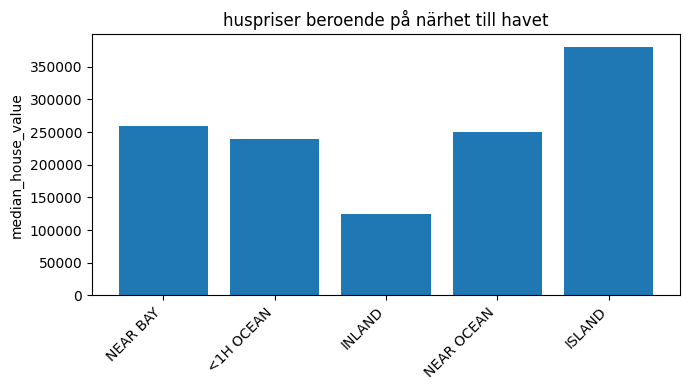

In [17]:
cats = df["ocean_proximity"].unique()
means = [df.loc[df["ocean_proximity"] == c, "median_house_value"].mean() for c in cats]

plt.figure(figsize=(7, 4))
plt.bar(range(len(cats)), means)
plt.xticks(range(len(cats)), cats, rotation=45, ha="right")
plt.ylabel("median_house_value")
plt.title("huspriser beroende på närhet till havet")
plt.tight_layout()
plt.show()


### Valda x och y, samt framställningen av dem

**Valda x och y**  
Efter att ha analyserat datan väljer jag (trots den skeva fördelingen i datan) att ha **median_house_value** som målvariabel (Y).  
Då kategorin innehåller medianvärdet av huspriser känns det ganska naturligt att se om de finns variabler som påverkar denna.  
  
För de oberoende variablerna (x) väljer jag **median_income** och **ocean_proximity** (dummy-variabler, med baseline). 

##### Hantering av saknade värden  
Tar bort rader med saknade värden i hela datasetet.  
  
OLS-regression kräver kompletta observationer (inga noll-värden).  
Rader med saknade värden i någon av de variabler som används tas därför bort.
(efter dataanalysen har jag inte sett några nollvärden för valda kategorier, men gör ändå dropna för att det är bra att alltid ha i åtanke)

In [18]:
df = df.dropna()

Delar upp variablernai  olika grupper då de ska behandlas olika hädan efter: 

In [19]:
num_cols_to_scale = [
    "housing_median_age", 
    "total_rooms", 
    "total_bedrooms", 
    "population", 
    "households", 
    "median_income"
]

coord_cols = ["longitude", "latitude"]
cat_col = "ocean_proximity"

y = df["median_house_value"] 

Skalerar de numeriska värdena i datan (förutom koordinater och målvariabeln median_house_value), Så alla värden ligger i samma skala för att underlätta tolkning av koefficienter och minska påverkan av outliers.

In [20]:
for col in num_cols_to_scale:
    df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

#### Oberoende variabel(variabler) (x₂​, x₃, x₄, x₅​):
**ocean_proximity** (dummy, INLAND som baseline)

Använder "dummies" som "hjälp-variabel" för att omvandla kategoriska varibler till numeriska. 

Väljer att ha INLAND som baseline då en stor andel av värdena i kategoring tillhör denna 
(plus att jag ocskå kan se den som lägst från havet).  
   
Väljer ordningen på kategorierna så att INLAND hamnar först (pga "drop_first=True):  

In [21]:
df["ocean_proximity"] = pd.Categorical(
    df["ocean_proximity"],
    categories=[
        "INLAND",        
        "<1H OCEAN",
        "NEAR OCEAN",
        "NEAR BAY",
        "ISLAND"
    ]
)

"drop_first=True" för att första ketegorin (INLAND) tas bort (och används som baseline/referensnivå).

In [22]:
ocean_proximity_dummies = pd.get_dummies(
    df["ocean_proximity"],
    drop_first=True
)

Vill ha 0 och 1 istället för true och false (så de visas som numeriska värden). Det gör egentligen "model.fit" i modellen åt oss, men för att vara tydlig: 

In [23]:
ocean_proximity_dummies = ocean_proximity_dummies.astype(int)

In [24]:
ocean_proximity_dummies.head()

,<1H OCEAN,NEAR OCEAN,NEAR BAY,ISLAND
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


NEAR BAY jämförs mot INLAND (baseline). Därför är NEAR BAY = 1. INLAND syns inte då den är vår referensnivån. (NEAR BAY endast då raderna i början av datasetet har det värdet). 

Någon Dummies = 1 - Den dummy som är "närvarande" (NEAR BAY), "skillnaden från INLAND". 
Alla Dummies = 0 - INLAND = 1 (interceptet)

#### Intercept
En kolumn med ettor läggs till för att möjliggöra ett intercept i modellen.  
(Interceptet representerar också basnivån (INLAND) när dummies från ocean_proximity är noll):

In [25]:
intercept = pd.Series(1, index=df.index, name="Intercept")

#### Designmatris X

Designmatrisen X byggs genom att kombinera:
- Intercept
- Dummy-variabler för ocean_proximity
- Den numeriska variabeln persons_per_household  
  
Resultatet är en helt numerisk matris som kan användas direkt i OLS.

In [26]:
X = pd.concat(
    [
        intercept,
        ocean_proximity_dummies,
        df[["median_income"]]
    ],
    axis=1
)

X.head()

,Intercept,<1H OCEAN,NEAR OCEAN,NEAR BAY,ISLAND,median_income
0,1,0,0,1,0,2.345163
1,1,0,0,1,0,2.332632
2,1,0,0,1,0,1.782939
3,1,0,0,1,0,0.932970
4,1,0,0,1,0,-0.013143


#### Slutlig data till modellen

In [27]:
X_mat = X
y_vec = y

- **X**: designmatris med intercept, dummies och numeriska prediktorer
- **y**: responsvektor (median_house_value)  

Nedan ser vi vad de innehåller: 

In [28]:
X_mat.shape, y_vec.shape, list(X.columns)

((20433, 6),
 (20433,),
 ['Intercept',
  '<1H OCEAN',
  'NEAR OCEAN',
  'NEAR BAY',
  'ISLAND',
  'median_income'])

### Undersöker eventuell **kollinearitet** med Pearsons korrelationskoefficient:

In [45]:
from linear_regression import LinearRegression
model = LinearRegression(alpha=0.05)
model.fit(X_mat, y_vec)

corr = model.pearson_X(X.values, include_intercept=False)
corr_df = pd.DataFrame(corr, index=X.columns[1:], columns=X.columns[1:])
corr_df


,<1H OCEAN,NEAR OCEAN,NEAR BAY,ISLAND,median_income
<1H OCEAN,1.000000,-0.342018,-0.314721,-0.013928,0.168715
NEAR OCEAN,-0.342018,1.000000,-0.135819,-0.006011,0.027351
NEAR BAY,-0.314721,-0.135819,1.000000,-0.005531,0.056677
ISLAND,-0.013928,-0.006011,-0.005531,1.000000,-0.009281
median_income,0.168715,0.027351,0.056677,-0.009281,1.000000


När vi bara jämför variablerna i X med varandra parvis kan vi få syn på om det kan finnas någon kolliearitet dem emellan. Om värdet < 0.8 visar det ingen stark linjär beroenderelation. om värdet > än 0.8 kan det vara ett tecken på hög kolliearitet (att variablerna är linjärt beroende av varandra). Kolliearitet kan leda till instabilitet i skattningen av regressionskoefficienterna, då matrisen som inverteras vid OLS då kan bli numeriskt instabil.  
  
Då inga av variablerna i X parvis visar ett värde över 0.8 ser vi inga tecken på kolliearitet utifrån Pearsons korrelationskoefficient. 

## Resultat

#### Skattade regressionskoefficienter

In [30]:
for name, coef in zip(X.columns, model.b):
    print(f"{name:30s} {coef:10.2f}")


Intercept                       149383.33
<1H OCEAN                        77546.90
NEAR OCEAN                       94648.63
NEAR BAY                         98613.07
ISLAND                          272808.79
median_income                    70377.71


Resultaten visar att både geografiskt läge och medianinkomst har en betydande påverkan på husvärdet.  
  
**median_income**  
Koefficienten för median_income är cirka 70 378.  
Detta innebär att:

En ökning av median_income med en enhet är förknippad med en genomsnittlig ökning av husvärdet på cirka 70 378 dollar, givet samma geografiska läge. Median income framstår därmed som en **stark prediktor** för husvärde i modellen.  
  
**Dummyvariabler**  
Koefficienterna för: 
- Hus belägna <1H OCEAN är i genomsnitt cirka 77 547 dollar dyrare än motsvarande inland-hus.
- Hus NEAR OCEAN är cirka 94 649 dollar dyrare.
- Hus NEAR BAY är cirka 98 613 dollar dyrare.
- Hus på ISLAND är cirka 272 809 dollar dyrare.  
  
Dummyvariablerna anger skillnaden i genomsnittligt husvärde jämfört med referenskategorin INLAND, givet samma median_income.  
Detta visar en **tydlig geografisk påverkan** på huspriser, där kustnära lägen generellt är mer värdefulla än inlandslägen.  

#### F-test, Signifikans för hela regressionen

F-testet används för att testa nollhypotesen för hela modellen (att samtliga lutningsparametrar är noll,
dvs. att modellen saknar förklaring). 


In [46]:
F_stat, p_val = model.f_test()
print("F-statistic:", F_stat)
print("p-value:", p_val)


F-statistic: 5833.696917770225
p-value: 0.0


F = enormt stort (5834) och p-värdet lågt (0.0..) jämfört med alpha (0.05). Det gör att vi kan förkasta nollhypotesen och anta att modellen i sin helhet är statistiskt signifikant. 

#### t-test, Signifikans för enskilda parametrar

Varje regressionskoefficient testas individuellt mot nollhypotesen βᵢ = 0.  
Tolkning:  
  
p < α → parametern bidrar signifikant  
  
p ≥ α → inget statistiskt stöd för effekt  

In [32]:
tests = model.t_tests()

for name, b, t, p in zip(X.columns, model.b, tests["t"], tests["p"]):
    print(f"{name:30s} beta={b:9.2f}  t={t:7.2f}  p={p:.4g}")


Intercept                      beta=149383.33  t= 159.28  p=0
<1H OCEAN                      beta= 77546.90  t=  62.59  p=0
NEAR OCEAN                     beta= 94648.63  t=  54.79  p=0
NEAR BAY                       beta= 98613.07  t=  53.98  p=0
ISLAND                         beta=272808.79  t=   8.23  p=1.984e-16
median_income                  beta= 70377.71  t= 131.78  p=0


ISLAND hara många färre observationer än övriga dummy-variabler vilket ökar osäkerheten i skattningen och ger ett lägre t-värde. Dock blir effekten fortfarande starkt signifikant. 

#### Konfidensintervall för regressionskoefficienter

In [33]:
ci_low, ci_high = model.confidence_intervals()

for name, lo, hi in zip(X.columns, ci_low, ci_high):
    print(f"{name:30s} CI [{lo:.1f}, {hi:.1f}]")


Intercept                      CI [147545.0, 151221.6]
<1H OCEAN                      CI [75118.3, 79975.5]
NEAR OCEAN                     CI [91262.7, 98034.6]
NEAR BAY                       CI [95032.4, 102193.7]
ISLAND                         CI [207835.7, 337781.9]
median_income                  CI [69331.0, 71424.5]


Ingen av variablerna har ett konfidensintervall som inkluderar noll, vilket bekräftar deras statistiska signifikans. ISLAND visar på bredare intervall, vilket indikerar på större osäkerhet vid skattningen, sannolikt på grund av få observationer. 

#### Förklaringsgrad (R²)

R² anger hur stor andel av variationen i median_house_value
som förklaras av modellen.


In [34]:
print("R²:", model.R2)


R²: 0.5881278271733651


59% av variationen förklaras av modellen (41% oförklarat/kvar i residualerna), vilket kan ses som en bra andel inom området (datatypen). 

#### Prediktioner  
  
Då datan är gammal och egentligen inte kan användas för prediktioner på framtida y, bör detta snarare ses som en "retrodiktion". Modellen bör inte tolkas som ett prognosverktyg utan snarare som en förklaringsmodell för perioden. 


In [37]:
y_hat = model.predict(X_mat)
residuals = y_vec - y_hat

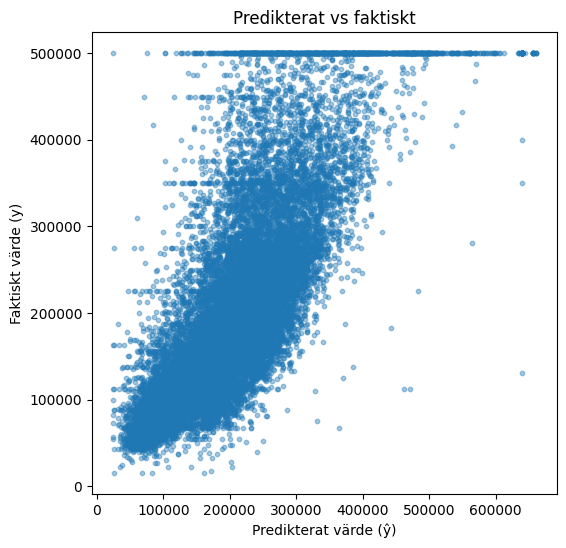

In [38]:
plt.figure(figsize=(6, 6))
plt.scatter(y_hat, y_vec, alpha=0.4, s=10)
plt.xlabel("Predikterat värde (ŷ)")
plt.ylabel("Faktiskt värde (y)")
plt.title("Predikterat vs faktiskt")
plt.show()


Predikterat vs faktiskt (vad fångar modellen)  
Ju närmare punkterna ligger en “diagonal” trend, desto bättre. Stor spridning = mycket som modellen inte fångar.  
  
Punkterna ligger relativt nära diagonalen, vilket är bra. Önskat värde är y(faktiskt värde) = ŷ(predikerat värde). Åter igen syns det att datan (y) är kapad vid 500.000, vilket ger många punkter på samma nivå. 

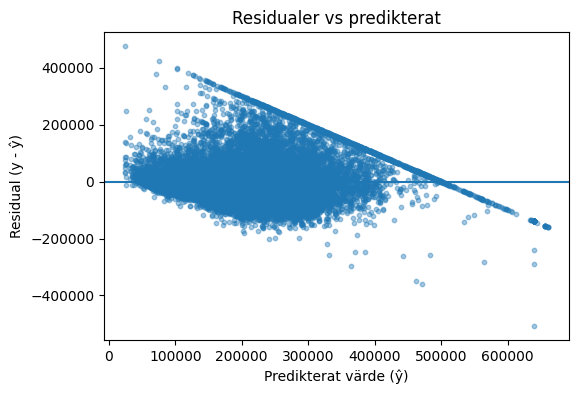

In [39]:
plt.figure(figsize=(6, 4))
plt.scatter(y_hat, residuals, alpha=0.4, s=10)
plt.axhline(0)
plt.xlabel("Predikterat värde (ŷ)")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residualer vs predikterat")
plt.show()


Resultatet visar residualer (det som modellen överskattade/"fel") som, bortsett från snedvridningen (cap), ligger kring nollan och utan tydlig kurvtrend. Vilket stödjer att det finns ett linjärt samband. 

VIsar även med ett histogram: 

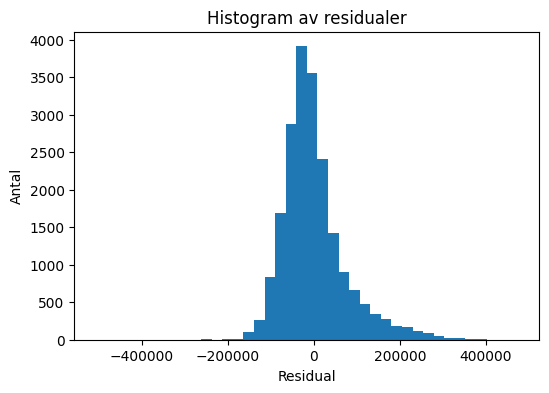

In [40]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40)
plt.xlabel("Residual")
plt.ylabel("Antal")
plt.title("Histogram av residualer")
plt.show()


#### Konfidensintervall

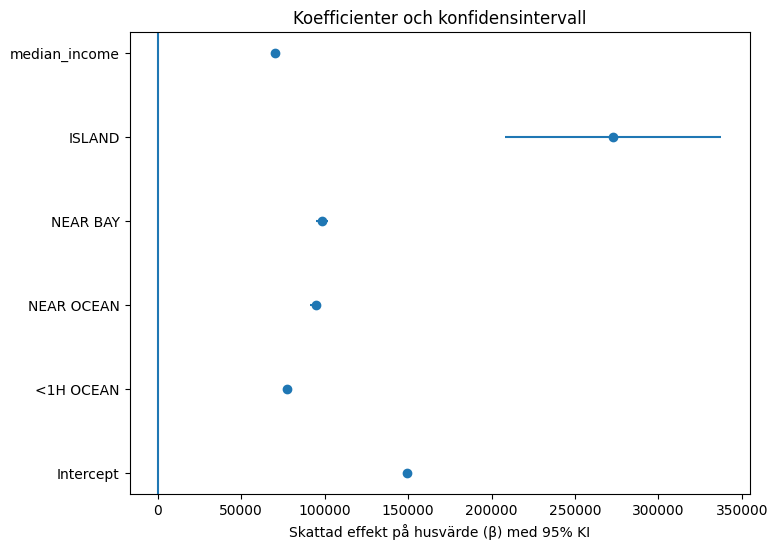

In [42]:
ci_low, ci_high = model.confidence_intervals()

coef = model.b
names = list(X.columns)

plt.figure(figsize=(8, 6))
ypos = np.arange(len(names))
plt.errorbar(coef, ypos, xerr=[coef - ci_low, ci_high - coef], fmt="o")
plt.axvline(0)
plt.yticks(ypos, names)
plt.xlabel("Skattad effekt på husvärde (β) med 95% KI")
plt.title("Koefficienter och konfidensintervall")
plt.show()


Att inga av variablerna KI korsar 0 visar på signifikans. dummie-variablerna från ocean_proximitys punkter (relativt INLAND), visar på att havsnära lägen är dyrare än INLAND. ISLAND har dock en mycket hög beta med brett konfidensintervall, vilket tyder på stor effekt, men ocskå stor osäkerhet (åter igen möjligen pga få observationer).  

#### RMSE - Root Mean Squared Error

In [48]:
mean_price = np.mean(y)
rmse = model.rmse(X, y)

rmse_percent = rmse / mean_price * 100
rmse_percent


np.float64(35.81169107520996)

RMSE beräknades till  ungefär 36 % av det genomsnittliga husvärdet.  
Detta innebär att modellen i genomsnitt avviker från det faktiska husvärdet med cirka en tredjedel av medelpriset.  
  
Eftersom RMSE här beräknas på samma data som modellen tränats på ger det ett mått på modellens anpassning snarare än dess generaliseringsförmåga.  

# Diskussion

Resultaten från regressionen visar att både geografiskt läge och medianinkomst påverkar husvärdet tydligt. Hus som ligger närmare havet är generellt dyrare än hus i inlandet, vilket syns genom de positiva koefficienterna för kustnära områden. Median income har också en stark positiv effekt, vilket innebär att områden med högre inkomstnivå tenderar att ha högre huspriser.  
  
Modellens träffsäkerhet mättes med RMSE. Resultatet visar att modellen i genomsnitt missar det verkliga husvärdet med ungefär 36 % av medelpriset. Det betyder att modellen fångar en del av sambandet, men att den fortfarande har en ganska stor felmarginal.  
  
En möjlig anledning till att felet är relativt stort är att modellen bara innehåller två typer av variabler: läge och medianinkomst. Husvärde påverkas sannolikt även av andra faktorer, till exempel bostadens storlek, antal rum eller befolkning i området. Genom att inkludera fler relevanta variabler skulle modellen kunna bli mer exakt.  
  
Sammanfattningsvis visar modellen rimliga och logiska samband, men den är relativt enkel och kan förbättras för att ge mer precisa förutsägelser.